In [1]:
pip install cleverhans --upgrade

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torchattacks

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchattacks import PGD


/opt/conda/lib/python3.10/site-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
2024-04-25 09:48:16.719483: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 09:48:16.719619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 09:48:16.855074: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 64 * 7 * 7)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 11301604.91it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 28881/28881 [00:00<00:00, 333122.58it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 3136317.87it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8211434.81it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = NeuralNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
pgd_attack = PGD(model, eps=0.3, alpha=2/255, steps=40, random_start=True)


# **PGD**

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function to display images
def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

pgd_attack = PGD(model, eps=0.3, alpha=2/255, steps=40, random_start=True)

num_epochs = 10
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Zero gradients, forward pass, backward pass, optimize
        optimizer.zero_grad()
        
        # Generate adversarial examples using PGD
        adv_images = pgd_attack(images, labels)
        
        outputs = model(adv_images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Evaluate model on test set
    model.eval()
    correct_test = 0
    total_test = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
    
    test_accuracy = correct_test / total_test
    test_accuracies.append(test_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Test Accuracy: {test_accuracy:.4f}')



Epoch [1/10], Train Loss: 0.3116, Train Accuracy: 0.8983, Test Accuracy: 0.9132
Epoch [2/10], Train Loss: 0.1676, Train Accuracy: 0.9444, Test Accuracy: 0.9382
Epoch [3/10], Train Loss: 0.1336, Train Accuracy: 0.9566, Test Accuracy: 0.9612
Epoch [4/10], Train Loss: 0.1132, Train Accuracy: 0.9624, Test Accuracy: 0.9691
Epoch [5/10], Train Loss: 0.0988, Train Accuracy: 0.9672, Test Accuracy: 0.9738
Epoch [6/10], Train Loss: 0.0881, Train Accuracy: 0.9711, Test Accuracy: 0.9688
Epoch [7/10], Train Loss: 0.0806, Train Accuracy: 0.9723, Test Accuracy: 0.9827
Epoch [8/10], Train Loss: 0.0728, Train Accuracy: 0.9757, Test Accuracy: 0.9690
Epoch [9/10], Train Loss: 0.0660, Train Accuracy: 0.9780, Test Accuracy: 0.9744
Epoch [10/10], Train Loss: 0.0614, Train Accuracy: 0.9793, Test Accuracy: 0.9708


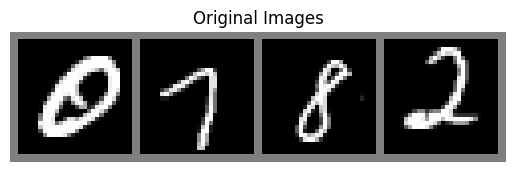

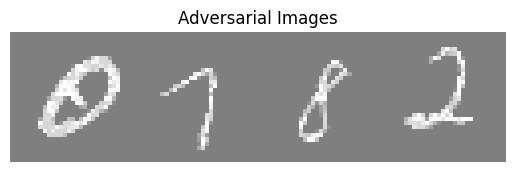

In [12]:
# Generate and display a few original and adversarial images after all epochs
model.eval()
display_count = 4
for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    adv_images = pgd_attack(images, labels)
    
    imshow(torchvision.utils.make_grid(images[:display_count].cpu().detach()), 'Original Images')
    imshow(torchvision.utils.make_grid(adv_images[:display_count].cpu().detach()), 'Adversarial Images')
    break  # Only display images from the first batch


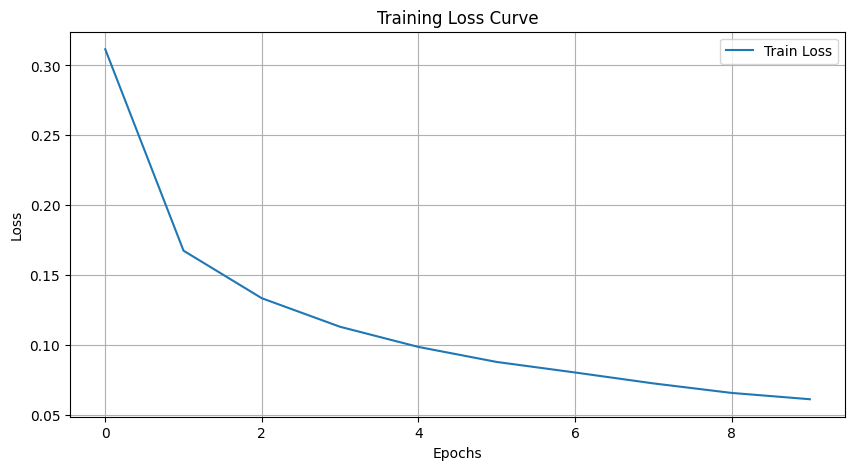

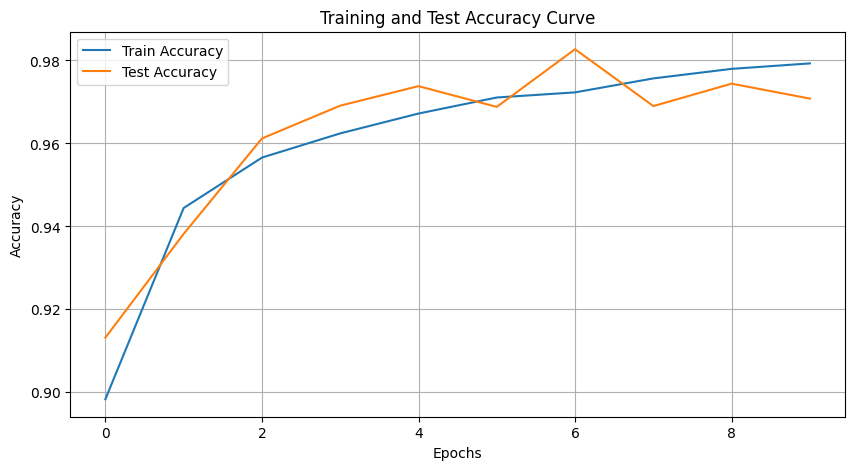

In [13]:
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()

# **FGSM**

In [14]:
from torchattacks import FGSM
import numpy as np
import matplotlib.pyplot as plt

# Define a function to display images
def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

fgsm_attack = FGSM(model, eps=0.3)

num_epochs = 10
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Generate adversarial examples using FGSM
        adv_images = fgsm_attack(images, labels)
        
        # Zero gradients, forward pass, backward pass, optimize
        optimizer.zero_grad()
        outputs = model(adv_images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Evaluate model on test set
    model.eval()
    correct_test = 0
    total_test = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
    
    test_accuracy = correct_test / total_test
    test_accuracies.append(test_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Test Accuracy: {test_accuracy:.4f}')

Epoch [1/10], Train Loss: 0.0229, Train Accuracy: 0.9927, Test Accuracy: 0.9793
Epoch [2/10], Train Loss: 0.0199, Train Accuracy: 0.9936, Test Accuracy: 0.9761
Epoch [3/10], Train Loss: 0.0173, Train Accuracy: 0.9942, Test Accuracy: 0.9806
Epoch [4/10], Train Loss: 0.0138, Train Accuracy: 0.9956, Test Accuracy: 0.9790
Epoch [5/10], Train Loss: 0.0151, Train Accuracy: 0.9952, Test Accuracy: 0.9870
Epoch [6/10], Train Loss: 0.0120, Train Accuracy: 0.9959, Test Accuracy: 0.9766
Epoch [7/10], Train Loss: 0.0105, Train Accuracy: 0.9961, Test Accuracy: 0.9830
Epoch [8/10], Train Loss: 0.0093, Train Accuracy: 0.9969, Test Accuracy: 0.9827
Epoch [9/10], Train Loss: 0.0080, Train Accuracy: 0.9976, Test Accuracy: 0.9838
Epoch [10/10], Train Loss: 0.0091, Train Accuracy: 0.9967, Test Accuracy: 0.9791


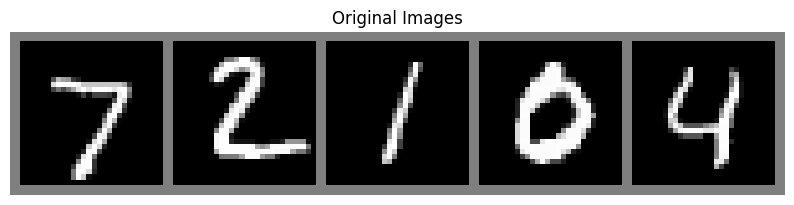

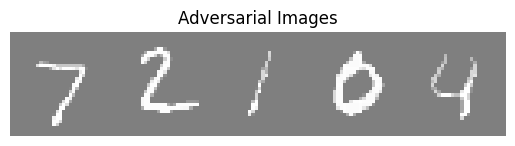

<Figure size 640x480 with 0 Axes>

In [15]:
# Generate and display a few original and adversarial images after training
num_images_to_show = 5
model.eval()

# Create separate grids for original and adversarial images
original_images_grid = []
adversarial_images_grid = []

for i in range(num_images_to_show):
    image, label = test_dataset[i][0].unsqueeze(0).to(device), torch.tensor(test_dataset[i][1]).unsqueeze(0).to(device)
    adv_image = fgsm_attack(image, label)
    
    # Append original and adversarial images to their respective grids
    original_images_grid.append(torchvision.utils.make_grid(image.cpu().detach()))
    adversarial_images_grid.append(torchvision.utils.make_grid(adv_image.cpu().detach()))

# Display original images in one row and adversarial images in the next row
plt.figure(figsize=(10, 5))

# Original images row
plt.subplot(2, 1, 1)
imshow(torchvision.utils.make_grid(original_images_grid, nrow=num_images_to_show), 'Original Images')

# Adversarial images row
plt.subplot(2, 1, 2)
imshow(torchvision.utils.make_grid(adversarial_images_grid, nrow=num_images_to_show), 'Adversarial Images')

plt.tight_layout()
plt.show()


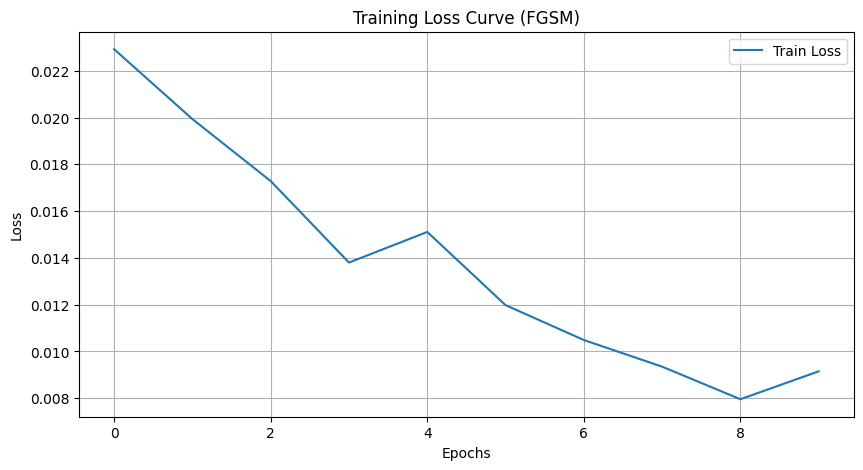

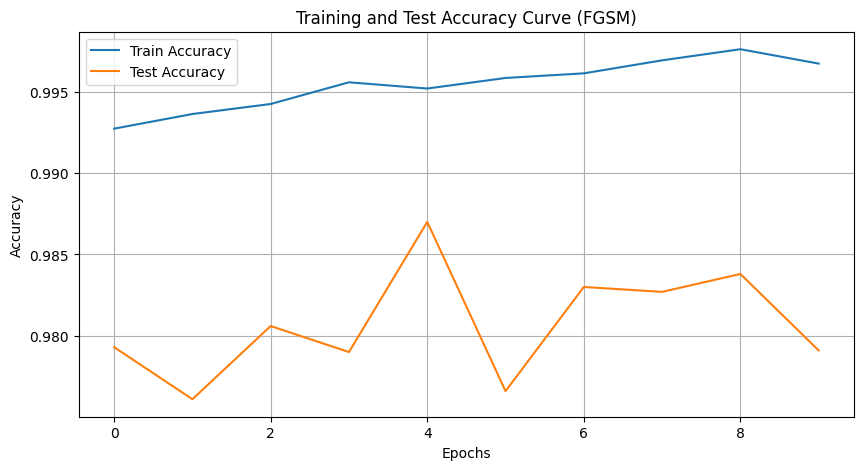

In [16]:
# Plotting the loss curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve (FGSM)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve (FGSM)')
plt.legend()
plt.grid(True)
plt.show()


# **DeepFool**

In [18]:
from torchattacks import DeepFool
import numpy as np
import matplotlib.pyplot as plt

# Define a function to display images
def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()
    
    
# Initialize DeepFool attack with the correct arguments
deepfool_attack = DeepFool(model, steps=10)

num_epochs = 2
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Generate adversarial examples using DeepFool
        adv_images = deepfool_attack(images, labels)
        
        # Zero gradients, forward pass, backward pass, optimize
        optimizer.zero_grad()
        outputs = model(adv_images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Evaluate model on test set
    model.eval()
    correct_test = 0
    total_test = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
    
    test_accuracy = correct_test / total_test
    test_accuracies.append(test_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Test Accuracy: {test_accuracy:.4f}')



Epoch [1/2], Train Loss: 1.4981, Train Accuracy: 0.6189, Test Accuracy: 0.9863
Epoch [2/2], Train Loss: 1.2022, Train Accuracy: 0.5120, Test Accuracy: 0.9854


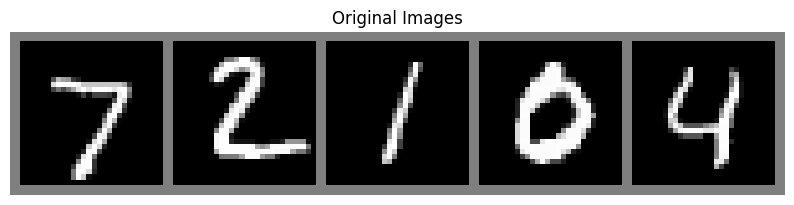

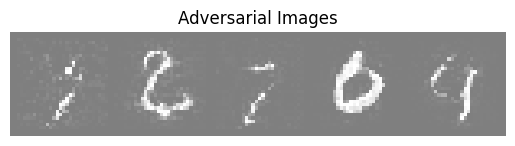

<Figure size 640x480 with 0 Axes>

In [21]:
# Generate and display a few original and adversarial images after training
num_images_to_show = 5
model.eval()

# Create separate grids for original and adversarial images
original_images_grid = []
adversarial_images_grid = []

for i in range(num_images_to_show):
    image, label = test_dataset[i][0].unsqueeze(0).to(device), torch.tensor(test_dataset[i][1]).unsqueeze(0).to(device)
    adv_image = deepfool_attack(image, label)
    
    # Append original and adversarial images to their respective grids
    original_images_grid.append(torchvision.utils.make_grid(image.cpu().detach()))
    adversarial_images_grid.append(torchvision.utils.make_grid(adv_image.cpu().detach()))

# Display original images in one row and adversarial images in the next row
plt.figure(figsize=(10, 5))

# Original images row
plt.subplot(2, 1, 1)
imshow(torchvision.utils.make_grid(original_images_grid, nrow=num_images_to_show), 'Original Images')

# Adversarial images row
plt.subplot(2, 1, 2)
imshow(torchvision.utils.make_grid(adversarial_images_grid, nrow=num_images_to_show), 'Adversarial Images')

plt.tight_layout()
plt.show()


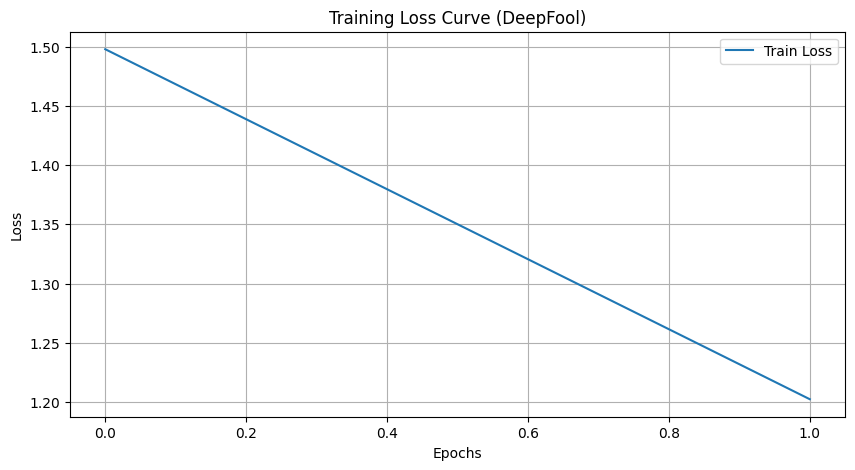

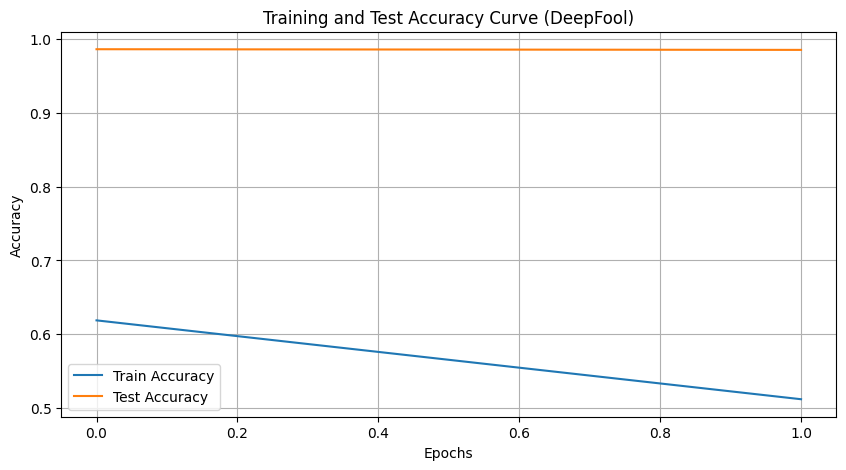

In [20]:
# Plotting the loss curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve (DeepFool)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve (DeepFool)')
plt.legend()
plt.grid(True)
plt.show()
